# MA Strategy with Position Resizing Based on Volatility
Volatility as measured throught the ATR

In [2]:
# auto reload
%load_ext autoreload
%autoreload 2

# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import core_metrics

In [3]:
def ma_position_resize(inv_amt, prices_df, short_ma, long_ma, 
                atr_cutoff = .75,
                transaction_costs=0.001,  # as a percent
                slippage=0.0005,  # as a percent
                  # Changed parameter name
                ):
    df = prices_df.copy()
    df = df.drop(columns=['Dividends', "Capital Gains", "Stock Splits"], errors="ignore") 

    df["MA_short"] = df["Close"].rolling(window=short_ma).mean()
    df["MA_long"] = df["Close"].rolling(window=long_ma).mean()

    Window = 14

    # ATR 
    df['TR'] = np.maximum(
    np.maximum(
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift(1))  
    ),
    np.abs(df['Close'].shift(1) - df['Low'])
    )
    df['ATR'] = df['TR'].rolling(window=Window).mean()
    
    df['ATR_pct'] = df['ATR'] / df['Close']

    target_vol = df['ATR_pct'].quantile(atr_cutoff)

    # position resizing
    min_position = 0.25
    max_position = 1

    df['position_size_ratio'] = np.clip(
        target_vol / df['ATR_pct'],
        min_position,  # Minimum 25% of capital
        max_position   # Maximum 100% of capital
    )

    # signal for trading
    df["signal"] = 0
    df.loc[
        (df["MA_short"] > df["MA_long"]) & 
        (df['ATR'].notna()),  # Ensure ATR is valid
        "signal"
    ] = 1

    # cost calculations
    total_cost = transaction_costs + slippage
    df["position"] = df["signal"].diff()
    df["trade_cost"] = 0.0
    df.loc[df['position'] != 0, 'trade_cost'] = total_cost

    # calculate returns
    df['market_ret'] = df['Close'].pct_change()
    df['strategy_ret'] = df['market_ret'] * df['signal'].shift(1) * df['position_size_ratio'].shift(1)
    df['strategy_ret_net'] = df['strategy_ret'] - df['trade_cost']
    
    # Market portfolio - buy at beginning, hold for the whole time
    df['market_ret_net'] = df['market_ret'].copy()
    df.loc[df.index[0], 'market_ret_net'] = df.loc[df.index[0], 'market_ret'] - total_cost

    # Calculate cumulative returns
    df['cumulative_market'] = (1 + df['market_ret_net']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_ret_net']).cumprod()
    
    # Portfolio value
    df['portfolio_value'] = inv_amt * df['cumulative_strategy']
    df['market_portfolio_value'] = inv_amt * df['cumulative_market']  # Add this for consistency metrics

    df = df.set_index("Date", inplace=False, drop=True, append=False)
    df.index = pd.to_datetime(df.index).tz_localize(None).normalize()

    return df

In [4]:
# running the strategy
# constants
investment_amount = 10000
test_data = pd.read_csv("../data/processed/training_data_70.csv")
short_ma = 20
long_ma = 50
atr_quantile = .75
result = ma_position_resize(investment_amount, test_data, short_ma, long_ma, atr_quantile, transaction_costs=0.001, slippage=0.0005)

In [14]:
result.tail()

,Open,High,Low,Close,Volume,MA_short,MA_long,TR,ATR,ATR_pct,...,position,trade_cost,market_ret,strategy_ret,strategy_ret_net,market_ret_net,cumulative_market,cumulative_strategy,portfolio_value,market_portfolio_value
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-01,374.407182,378.114169,371.691250,377.771118,78740100,395.322708,381.919368,6.422919,5.981842,0.015835,...,0.0,0.0,0.003138,0.003068,0.003068,0.003138,2.214503,1.594089,15940.888932,22145.026369
2022-09-02,381.449562,382.669345,371.967630,373.787781,99632100,394.311145,382.189626,10.701716,6.426328,0.017192,...,0.0,0.0,-0.010544,-0.010399,-0.010399,-0.010544,2.191152,1.577512,15775.118993,21911.522251
2022-09-06,374.635914,375.579332,370.147495,372.377411,76637400,393.251935,382.202587,5.431836,6.484184,0.017413,...,0.0,0.0,-0.003773,-0.003427,-0.003427,-0.003773,2.182885,1.572105,15721.053042,21828.846058
2022-09-07,372.062841,379.838970,371.843679,379.067078,70964200,392.605350,382.377738,7.995291,6.704042,0.017686,...,0.0,0.0,0.017965,0.016111,0.016111,0.017965,2.222100,1.597434,15974.339415,22220.995800
2022-09-08,376.789585,382.002231,375.579312,381.544830,80821700,391.670975,382.753773,6.422919,6.951130,0.018218,...,0.0,0.0,0.006536,0.005772,0.005772,0.006536,2.236624,1.606654,16066.538197,22366.242209


In [6]:
# export as csv in the data file
csv_name = "ma_position_resizing.csv"
output_folder = "../data/strategy_results/"

from file_exports import export_file
export_file(csv_name, output_folder, result)

Exported data as file ../data/strategy_results/ma_position_resizing.csv successfully.


In [15]:
# prelim test on final strategy portfolio value given varying threshold levels
thresholds = [.50, .55, .6, .65, .7, .75, .8]
for t in thresholds:
    res = ma_position_resize(investment_amount, test_data, short_ma, long_ma, t, transaction_costs=0.001, slippage=0.0005)
    print(f"ATR Quantile cutoff = {t}, final value = {res['portfolio_value'].iloc[-1]}")

ATR Quantile cutoff = 0.5, final value = 14923.311224255493
ATR Quantile cutoff = 0.55, final value = 15174.929075433582
ATR Quantile cutoff = 0.6, final value = 15410.84835736161
ATR Quantile cutoff = 0.65, final value = 15719.572131576468
ATR Quantile cutoff = 0.7, final value = 15832.781626062375
ATR Quantile cutoff = 0.75, final value = 16066.538196736761
ATR Quantile cutoff = 0.8, final value = 16550.926379199245


## Core Performance Metrics
To evaluate the basline strategy, we will perform the following tests.


### 1. Profit & Loss Metrics
Let's examine the returns and P&L of the strategy and market portfolios, considering transaction cost and slippage amounts as defined above.

Final portfolio value: 16066.538196736761 on 2022-09-08 00:00:00
Strategy returned 60.665381967367615% from 2015-01-02 00:00:00 to 2022-09-08 00:00:00
Market returned 123.66242209135079 from 2015-01-02 00:00:00 to 2022-09-08 00:00:00

Annualized across 7.6824 years: 
MA Strategy with Trend Detection returned 6.3664% per year
Buy & Hold the market returned 11.0467% per year


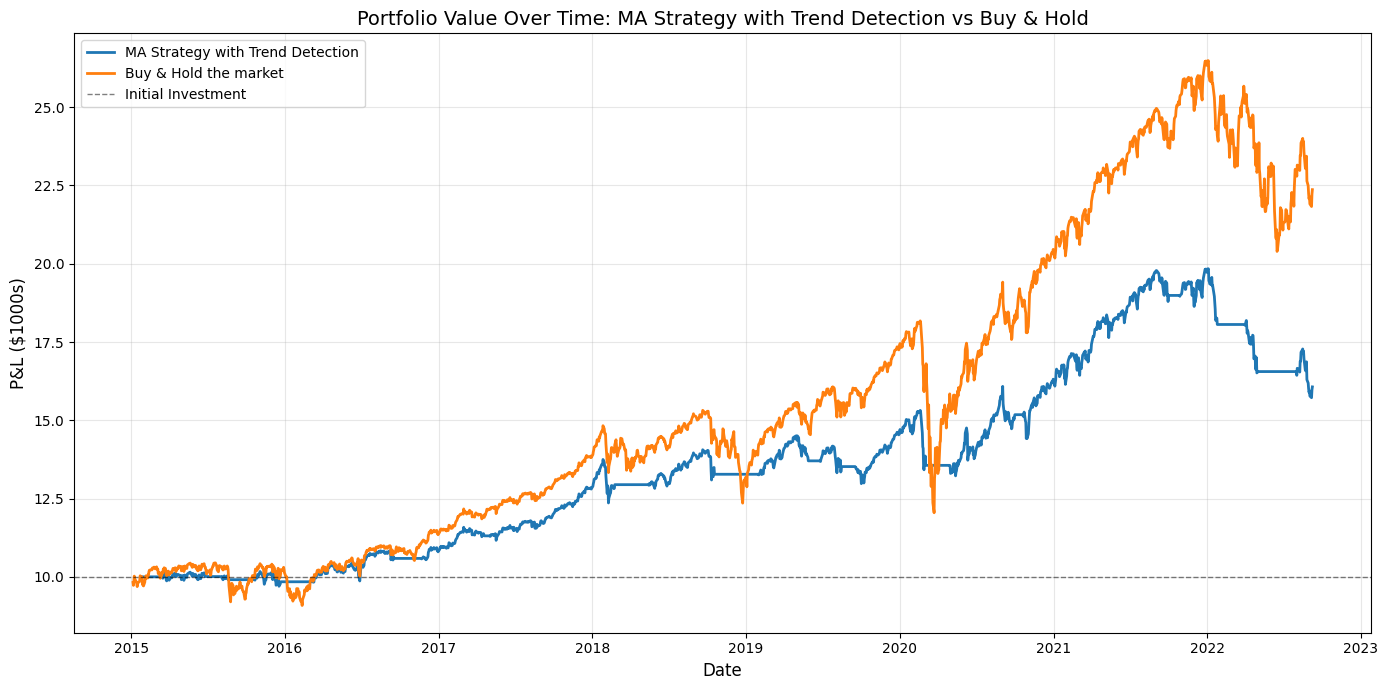

In [16]:
from core_metrics import pnl

graph_title = 'Portfolio Value Over Time: MA Strategy with Trend Detection vs Buy & Hold'
strategy_name = "MA Strategy with Trend Detection"
benchmark_name = "Buy & Hold the market"

result, strategy_annual_return, market_annual_return = pnl(result, investment_amount, strategy_name, benchmark_name, graph_title)

### 2. Performance Ratios

In [17]:
from core_metrics import performance_ratios

perf_ratios = performance_ratios(result)

print("WITHOUT transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe ratio']}")
print(f"Information Ratio: {perf_ratios['information ratio']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio']} \n")

print("WITH transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe with costs']}")
print(f"Information Ratios: {perf_ratios['information ratio with costs']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio with costs']}")


WITHOUT transaction costs...
Sharpe Ratio: 0.4704850527772484
Information Ratio: 9.24469716694545
Sortino Ratio: 8.002578615545493 

WITH transaction costs...
Sharpe Ratio: 0.40274640775417997
Information Ratios: 9.238869626651674
Sortino Ratio: 6.840150150615679


In [18]:
from core_metrics import risk_metrics

risks = risk_metrics(result)
print(f"Max Drawdown: {(100 * risks['max_drawdown']):.2f}%")
print(f"Average Drawdown: {(100 * risks['avg_drawdown']):.2f}%")
print(f"Max Drawdown Duration: {(risks['max_dd_duration']):.2f} days")
print(f"Average Drawdown Duration: {(risks['avg_dd_duration']):.2f} days")
print(f"Volatility: {(100 * risks['volatility']):.2f}%")

Max Drawdown: -20.77%
Average Drawdown: -3.62%
Max Drawdown Duration: 171.00 days
Average Drawdown Duration: 15.89 days
Volatility: 10.82%


### 4. Trade Statistics

In [19]:
from core_metrics import trade_statistics

trade_stats = trade_statistics(result)
print(f"Total Number of Trades: {trade_stats['num_trades']}")
print(f"Average Holding Periods: {trade_stats['avg_holding_period']}")
print(f"Win Rate: {trade_stats['win_rate']}")
print(f"Win-Loss Ratio: {trade_stats['win_loss_ratio']}")
print(f"Profit Factor (gross profit/gross loss): {trade_stats['profit_factor']}")


Total Number of Trades: 35
Average Holding Periods: 113.05882352941177
Win Rate: 0.6470588235294118
Win-Loss Ratio: inf
Profit Factor (gross profit/gross loss): 5.459718997147694


### 5. Strategy Beta to Benchmark

In [20]:
from core_metrics import find_alpha, calmar_ratio, find_beta

beta = find_beta(result, result.index[0], result.index[-1])
print(f'Beta: {beta}')
alpha = find_alpha(result, strategy_annual_return, market_annual_return)
print(f'Alpha: {alpha}')
calmar = calmar_ratio(strategy_annual_return, risks['max_drawdown'])
print(f'Calmar Ratio: {calmar:.2f}')

Beta: 0.3636877507042862
Alpha: 0.01071677775028429
Calmar Ratio: 0.31


### 5. Consistency of Returns

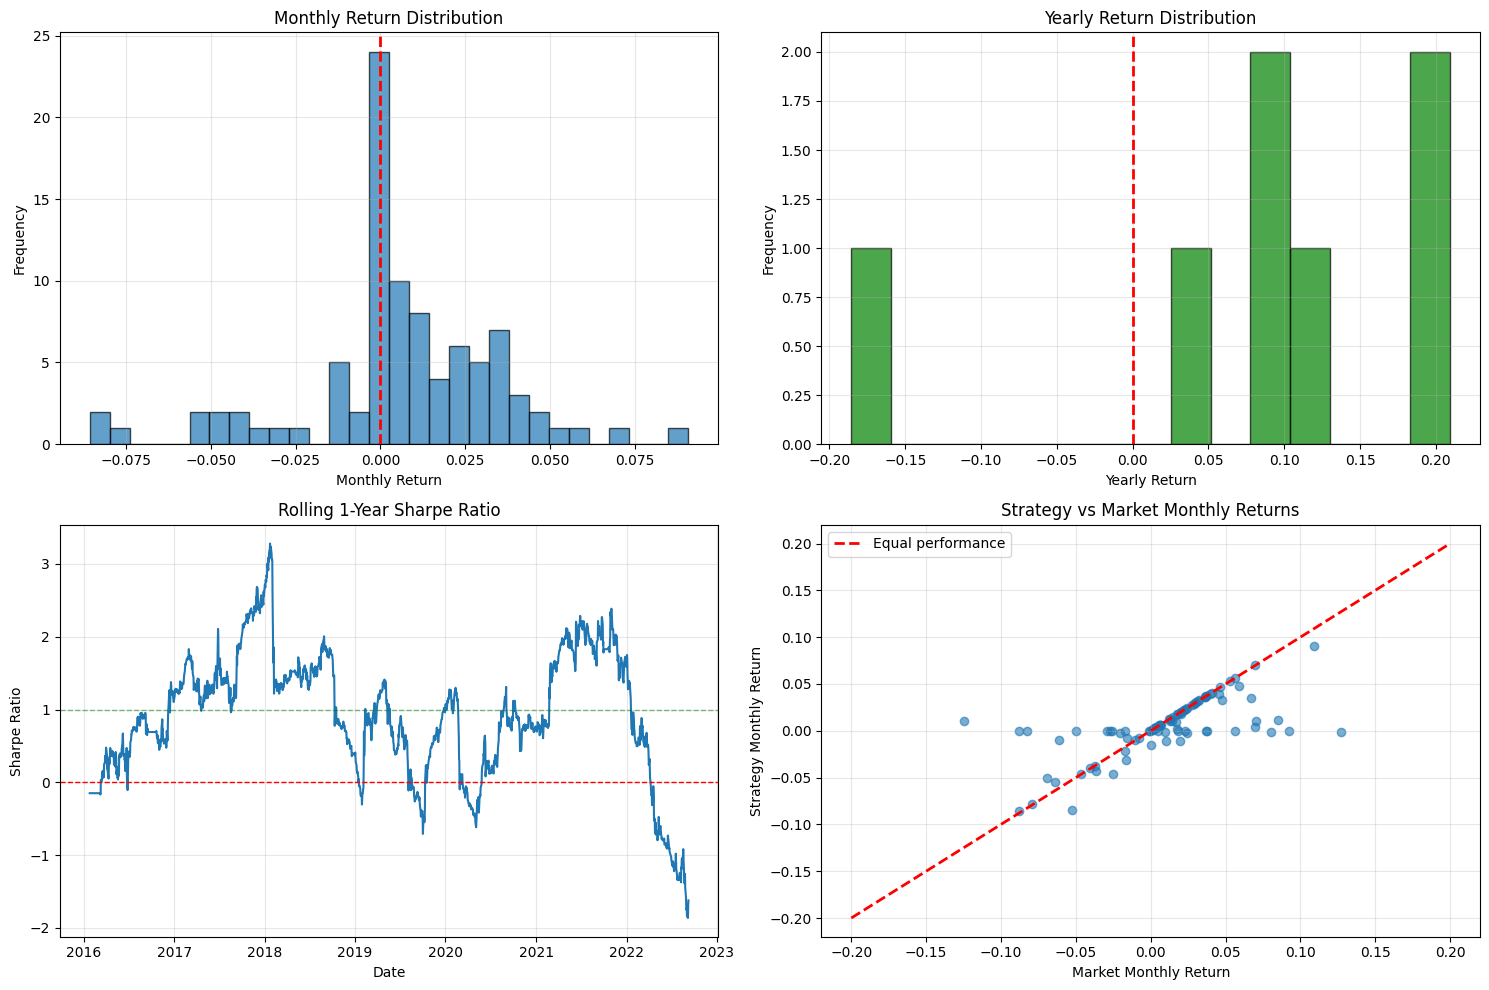

Percentage of Positive Months: 55.91%
Average Monthly Return: 0.56%
Median Monthly Return: 0.36%
Standard Deviation of Monthly Returns: 3.00%
Percentage of Positive Years: 75.00%
Average Yearly Return: 8.01%
Median Yearly Return: 9.75%


In [21]:
from core_metrics import consistency

window = 252 # trading days (for rolling sharpe)
consistency = consistency(result, window)

print(f"Percentage of Positive Months: {consistency['pct_positive_months']:.2%}")
print(f"Average Monthly Return: {consistency['avg_monthly_return']:.2%}")
print(f"Median Monthly Return: {consistency['median_monthly_return']:.2%}")
print(f"Standard Deviation of Monthly Returns: {consistency['std_monthly_return']:.2%}")

print(f"Percentage of Positive Years: {consistency['pct_positive_years']:.2%}")
print(f"Average Yearly Return: {consistency['avg_yearly_return']:.2%}")
print(f"Median Yearly Return: {consistency['median_yearly_return']:.2%}")


### 6. Sensitivity of Returns to Transaction Costs

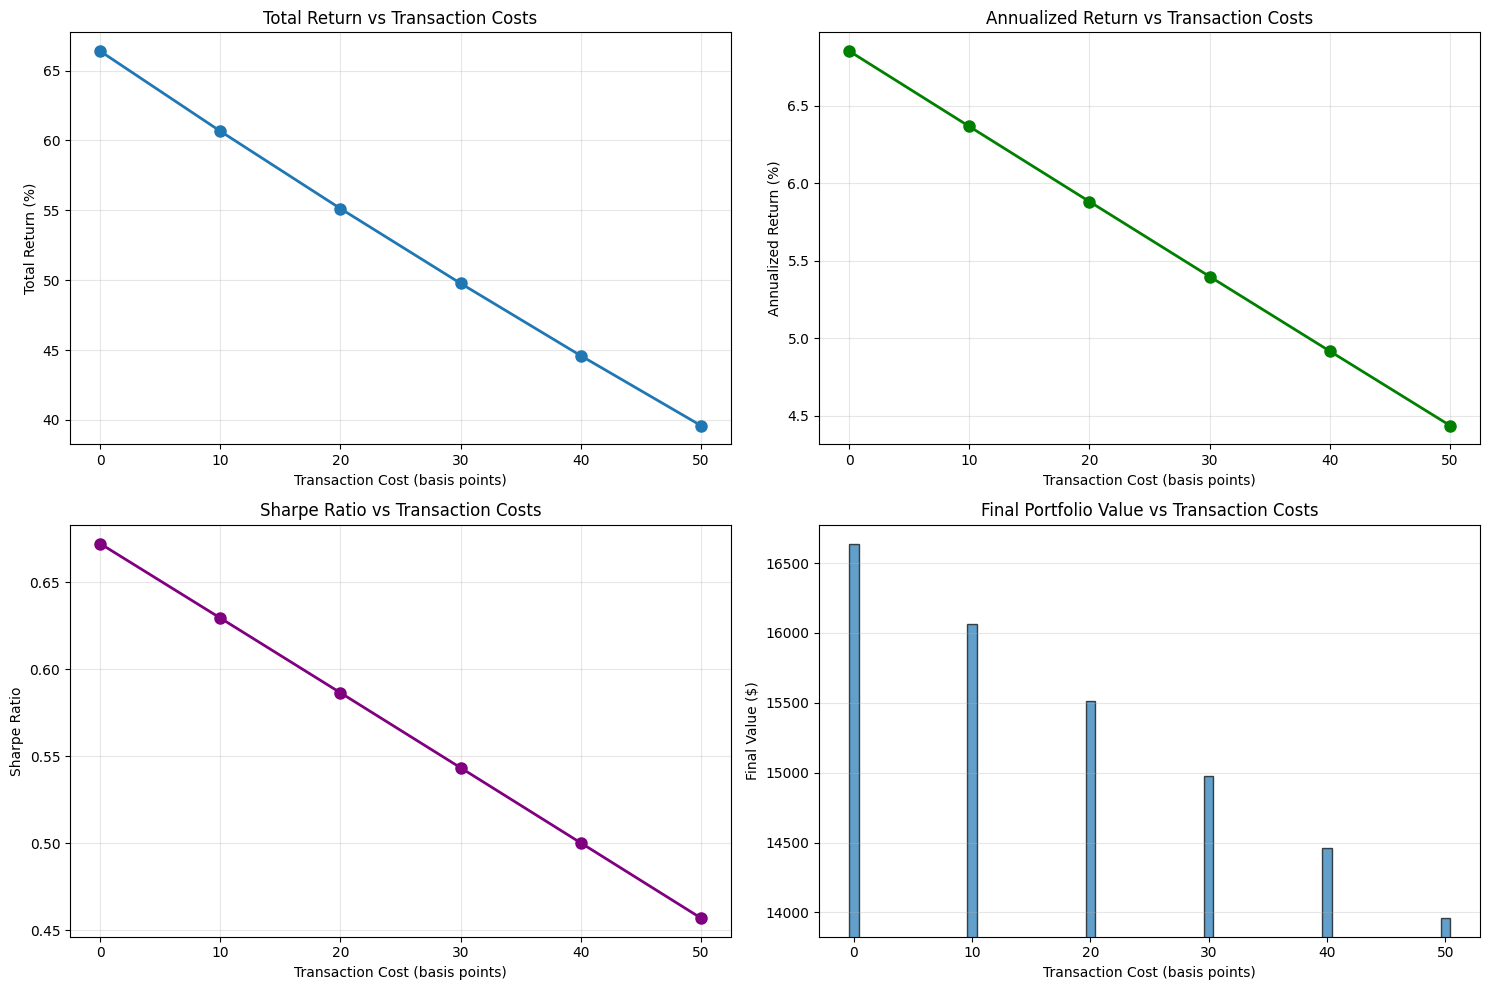

Transaction Cost Sensitivity Analysis
 cost_bps  cost_pct  total_return  annualized_return  sharpe_ratio  final_value
      0.0       0.0      0.663945           0.068526      0.672233 16639.452056
     10.0       0.1      0.606654           0.063664      0.629445 16066.538197
     20.0       0.2      0.551281           0.058819      0.586475 15512.805667
     30.0       0.3      0.497763           0.053991      0.543375 14977.630543
     40.0       0.4      0.446041           0.049181      0.500194 14460.408600
     50.0       0.5      0.396055           0.044387      0.456984 13960.554708


Strategy remains profitable at all tested cost levels


In [25]:
from core_metrics import sensitivity

prices_data = pd.read_csv("../data/processed/training_data_70.csv")

def ma_volatility_filter_helper(investment_amount, test_data, short_ma, long_ma, transaction_costs=0.001, slippage=0.0005):
    res = ma_position_resize(investment_amount, test_data, short_ma, long_ma, .75, transaction_costs, slippage)
    return res
df = sensitivity(ma_volatility_filter_helper, investment_amount, prices_data, short_ma, long_ma)